In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, r2_score
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import ast
import tensorflow as tf
from tensorflow.keras.models import load_model

# Cargar el dataset
dataset = pd.read_csv('./data/processed/dataset_final_small.csv')

# Crear columna categórica basada en pChEMBL
dataset['Union'] = dataset['pChEMBL'].apply(lambda x: 1 if x > 4 else 0)

pchembl = dataset['pChEMBL'].values
union = dataset['Union'].values  # Nueva etiqueta categórica

# Convertir las columnas de interés a arrays
n_hot_fgs = np.array([ast.literal_eval(x) for x in dataset['n_hot_fgs']])
one_hot_encoding = [np.array(ast.literal_eval(x)) for x in dataset['One_Hot_Encoding']]

# Ajustar el tamaño de la entrada de one_hot_encoding para tener dimensiones uniformes
max_length = max([len(x) for x in one_hot_encoding])
one_hot_encoding_padded = np.array([np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant') if x.ndim == 2 else np.pad(x, ((0, max_length - len(x)),), mode='constant') for x in one_hot_encoding])

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train_fgs, X_test_fgs, X_train_onehot, X_test_onehot, y_train_pchembl, y_test_pchembl, y_train_union, y_test_union = train_test_split(
    n_hot_fgs, one_hot_encoding_padded, pchembl, union, test_size=0.2, random_state=42
)

# Definir el modelo para la columna one_hot_encoding usando LSTM
input_onehot = Input(shape=(one_hot_encoding_padded.shape[1], one_hot_encoding_padded.shape[-1]))
lstm_layer = LSTM(64, return_sequences=True)(input_onehot)
lstm_layer = LSTM(32, return_sequences=False)(lstm_layer)  # Segunda capa LSTM
lstm_layer = Dropout(0.3)(lstm_layer)  # Añadir Dropout para prevenir sobreajuste

# Definir el modelo para la columna n_hot_fgs usando una red densa
input_fgs = Input(shape=(n_hot_fgs.shape[1],))
dense_layer_fgs = Dense(128, activation='relu', kernel_regularizer='l2')(input_fgs)
dense_layer_fgs = BatchNormalization()(dense_layer_fgs)  # Añadir normalización por lotes
dense_layer_fgs = Dropout(0.3)(dense_layer_fgs)

# Concatenar todas las salidas
concat = Concatenate()([lstm_layer, dense_layer_fgs])

# Capas densas adicionales para la predicción
dense_concat = Dense(128, activation='relu', kernel_regularizer='l2')(concat)
dense_concat = Dropout(0.3)(dense_concat)
dense_concat = Dense(64, activation='relu', kernel_regularizer='l2')(dense_concat)
dense_concat = Dropout(0.3)(dense_concat)

# Capa densa final para predecir pChEMBL
output_pchembl = Dense(1, activation='linear', name='pchembl_output')(dense_concat)

# Capa densa final para predecir Union (resultado categórico)
output_union = Dense(1, activation='sigmoid', name='union_output')(dense_concat)

# Definir el modelo con dos salidas
model = Model(inputs=[input_onehot, input_fgs], outputs=[output_pchembl, output_union])

# Mostrar el resumen del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'pchembl_output': 'mse', 'union_output': 'binary_crossentropy'},
              metrics={'pchembl_output': 'mae', 'union_output': 'accuracy'})

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    [X_train_onehot, X_train_fgs],
    {'pchembl_output': y_train_pchembl, 'union_output': y_train_union},
    validation_data=([X_test_onehot, X_test_fgs],
                     {'pchembl_output': y_test_pchembl, 'union_output': y_test_union}),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluar el modelo
loss, pchembl_loss, union_loss, pchembl_mae, union_accuracy = model.evaluate(
    [X_test_onehot, X_test_fgs],
    {'pchembl_output': y_test_pchembl, 'union_output': y_test_union}
)
print(f"pChEMBL MAE: {pchembl_mae}, Union Accuracy: {union_accuracy}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 20)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32, 64)         │         21,760 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         12,928 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 160)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         20,608 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pchembl_output (Dense)    │ (None, 1)              │             65 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ union_output (Dense)      │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 76,610 (299.26 KB)

 Trainable params: 76,354 (298.26 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - loss: 16.4079 - pchembl_output_loss: 12.4076 - pchembl_output_mae: 2.6292 - union_output_accuracy: 0.5425 - union_output_loss: 0.7902 - val_loss: 16.0150 - val_pchembl_output_loss: 12.7221 - val_pchembl_output_mae: 2.2369 - val_union_output_accuracy: 0.7762 - val_union_output_loss: 0.6481
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 11.2976 - pchembl_output_loss: 7.7974 - pchembl_output_mae: 2.1340 - union_output_accuracy: 0.6754 - union_output_loss: 0.6582 - val_loss: 13.7627 - val_pchembl_output_loss: 10.6672 - val_pchembl_output_mae: 2.0352 - val_union_output_accuracy: 0.8205 - val_union_output_loss: 0.5958
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.6389 - pchembl_output_loss: 6.3986 - pchembl_output_mae: 1.8945 - union_output_accuracy: 0.7444 - union_output_loss: 0.5339 - val_loss: 12.1797 - val_pchembl_output_loss: 9.1969 - val_pchembl_output_mae: 1.9607 - val_union_output_accuracy: 0.8345 - val_

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
R2 Score for pChEMBL: 0.845791636844776


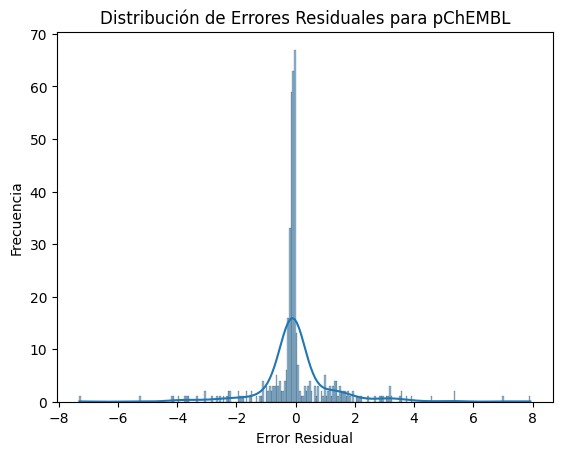

In [ ]:
# Calcular R2 para pChEMBL
y_pred_pchembl, y_pred_union = model.predict([X_test_onehot, X_test_fgs])
r2 = r2_score(y_test_pchembl, y_pred_pchembl)
print(f"R2 Score for pChEMBL: {r2}")

# Visualizar distribución de errores residuales para pChEMBL
residuals = y_test_pchembl - y_pred_pchembl.flatten()
sns.histplot(residuals, kde=True)
plt.title('Distribución de Errores Residuales para pChEMBL')
plt.xlabel('Error Residual')
plt.ylabel('Frecuencia')
plt.show()

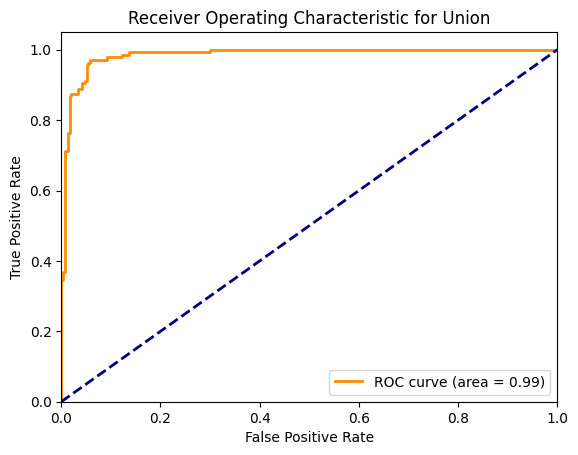

In [ ]:
# Generar curva ROC para Union
fpr, tpr, _ = roc_curve(y_test_union, y_pred_union)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Union')
plt.legend(loc="lower right")
plt.show()

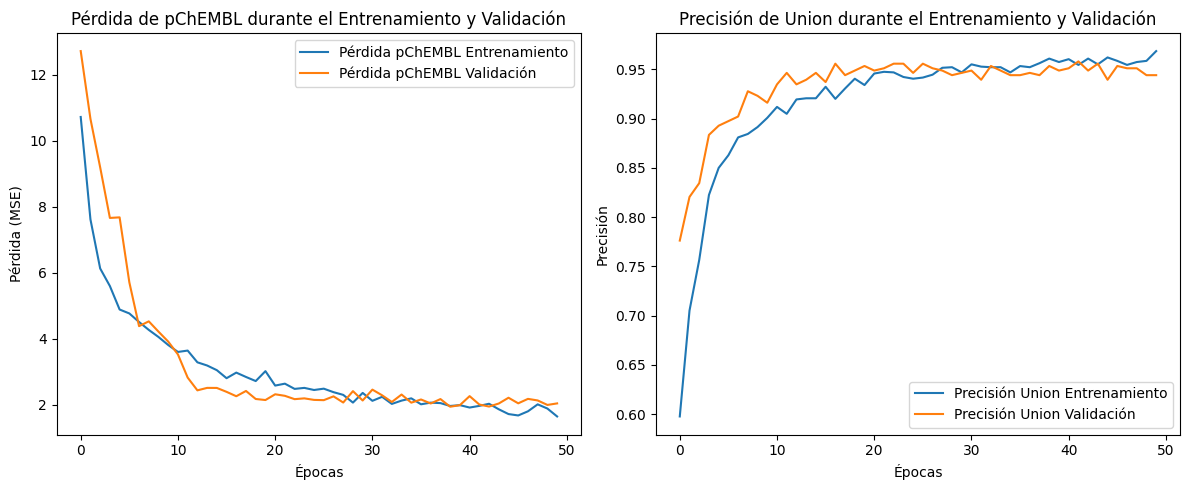

In [ ]:
# Graficar la pérdida de entrenamiento y validación para pChEMBL
plt.figure(figsize=(12, 5))

# Pérdida de pChEMBL
plt.subplot(1, 2, 1)
plt.plot(history.history['pchembl_output_loss'], label='Pérdida pChEMBL Entrenamiento')
plt.plot(history.history['val_pchembl_output_loss'], label='Pérdida pChEMBL Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Pérdida de pChEMBL durante el Entrenamiento y Validación')

# Precisión de Union
plt.subplot(1, 2, 2)
plt.plot(history.history['union_output_accuracy'], label='Precisión Union Entrenamiento')
plt.plot(history.history['val_union_output_accuracy'], label='Precisión Union Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión de Union durante el Entrenamiento y Validación')

plt.tight_layout()
plt.show()

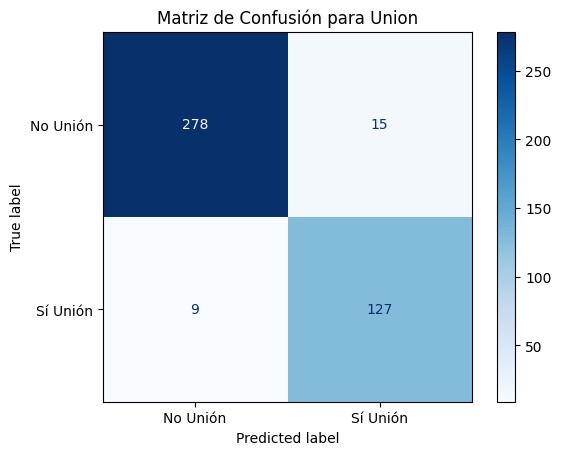

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar predicciones binarias para Union
y_pred_union_binary = (y_pred_union.flatten() > 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_union, y_pred_union_binary)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Unión', 'Sí Unión'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión para Union')
plt.show()

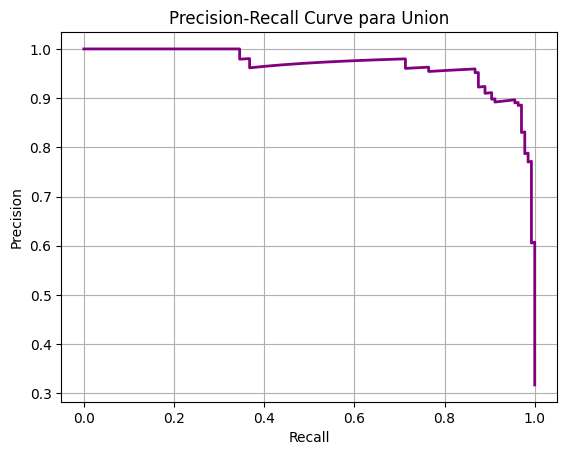

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calcular precision y recall
precision, recall, _ = precision_recall_curve(y_test_union, y_pred_union)

# Visualizar la curva Precision-Recall
plt.figure()
plt.plot(recall, precision, lw=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve para Union')
plt.grid()
plt.show()

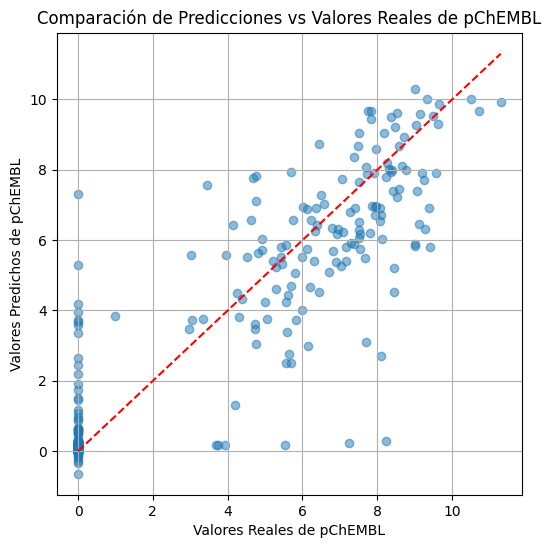

In [ ]:
# Comparar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pchembl, y_pred_pchembl, alpha=0.5)
plt.plot([min(y_test_pchembl), max(y_test_pchembl)], [min(y_test_pchembl), max(y_test_pchembl)], color='red', linestyle='--')
plt.xlabel('Valores Reales de pChEMBL')
plt.ylabel('Valores Predichos de pChEMBL')
plt.title('Comparación de Predicciones vs Valores Reales de pChEMBL')
plt.grid()
plt.show()

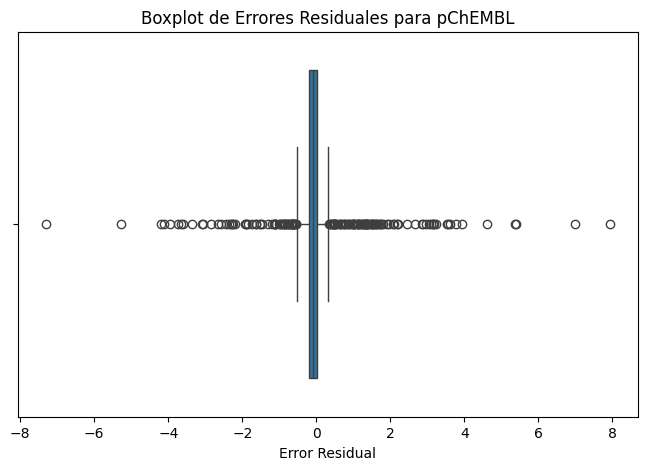

In [ ]:
# Crear boxplot de los errores residuales
plt.figure(figsize=(8, 5))
sns.boxplot(x=residuals)
plt.title('Boxplot de Errores Residuales para pChEMBL')
plt.xlabel('Error Residual')
plt.show()

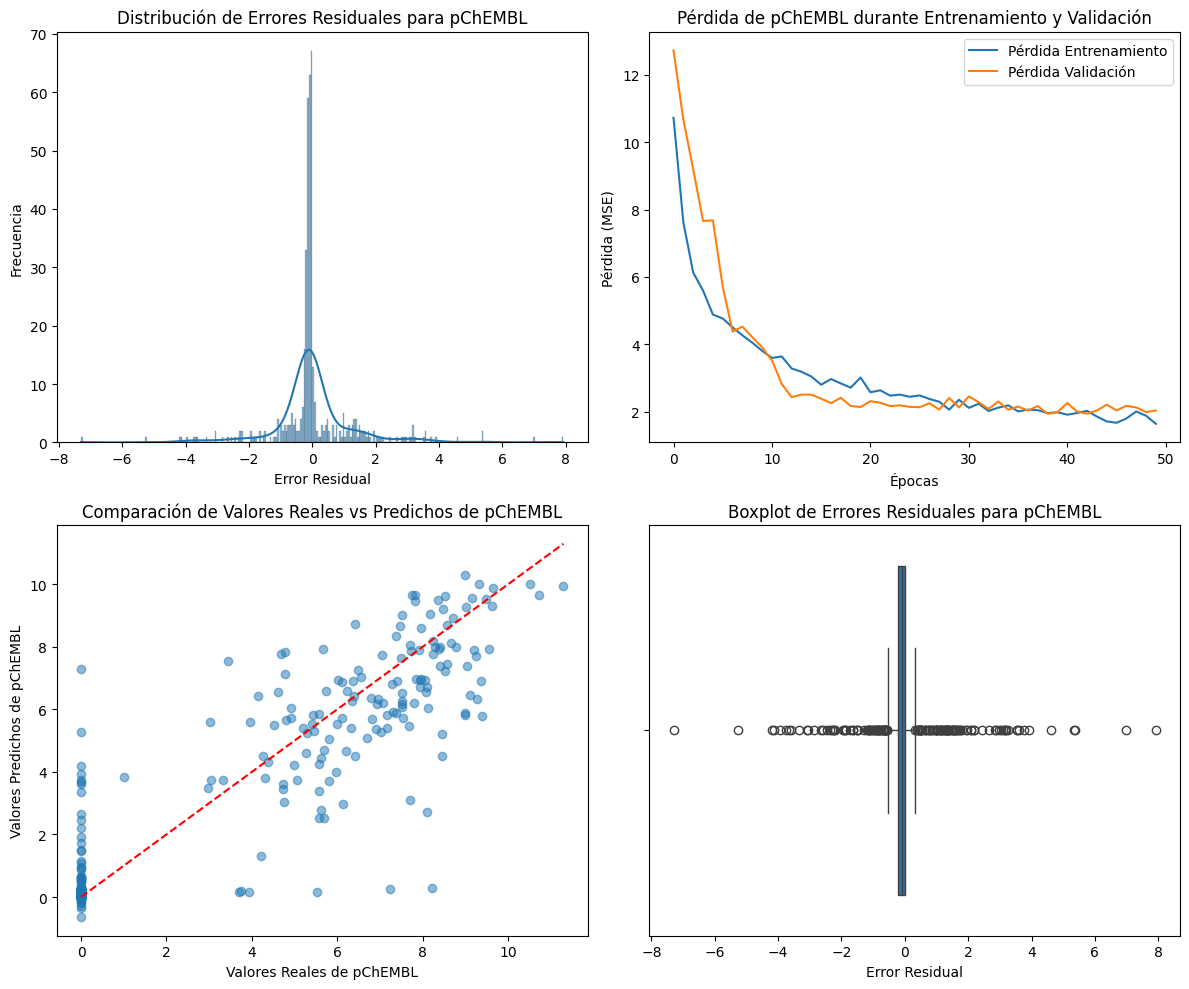

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Gráficas de evaluación para pChEMBL
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribución de errores residuales para pChEMBL
residuals = y_test_pchembl - y_pred_pchembl.flatten()
sns.histplot(residuals, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Errores Residuales para pChEMBL')
axes[0, 0].set_xlabel('Error Residual')
axes[0, 0].set_ylabel('Frecuencia')

# Pérdida de entrenamiento y validación para pChEMBL
axes[0, 1].plot(history.history['pchembl_output_loss'], label='Pérdida Entrenamiento')
axes[0, 1].plot(history.history['val_pchembl_output_loss'], label='Pérdida Validación')
axes[0, 1].set_title('Pérdida de pChEMBL durante Entrenamiento y Validación')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('Pérdida (MSE)')
axes[0, 1].legend()

# Comparación de valores predichos vs reales para pChEMBL
axes[1, 0].scatter(y_test_pchembl, y_pred_pchembl, alpha=0.5)
axes[1, 0].plot([min(y_test_pchembl), max(y_test_pchembl)], [min(y_test_pchembl), max(y_test_pchembl)], color='red', linestyle='--')
axes[1, 0].set_title('Comparación de Valores Reales vs Predichos de pChEMBL')
axes[1, 0].set_xlabel('Valores Reales de pChEMBL')
axes[1, 0].set_ylabel('Valores Predichos de pChEMBL')

# Boxplot de errores residuales para pChEMBL
sns.boxplot(x=residuals, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot de Errores Residuales para pChEMBL')
axes[1, 1].set_xlabel('Error Residual')

plt.tight_layout()
plt.show()

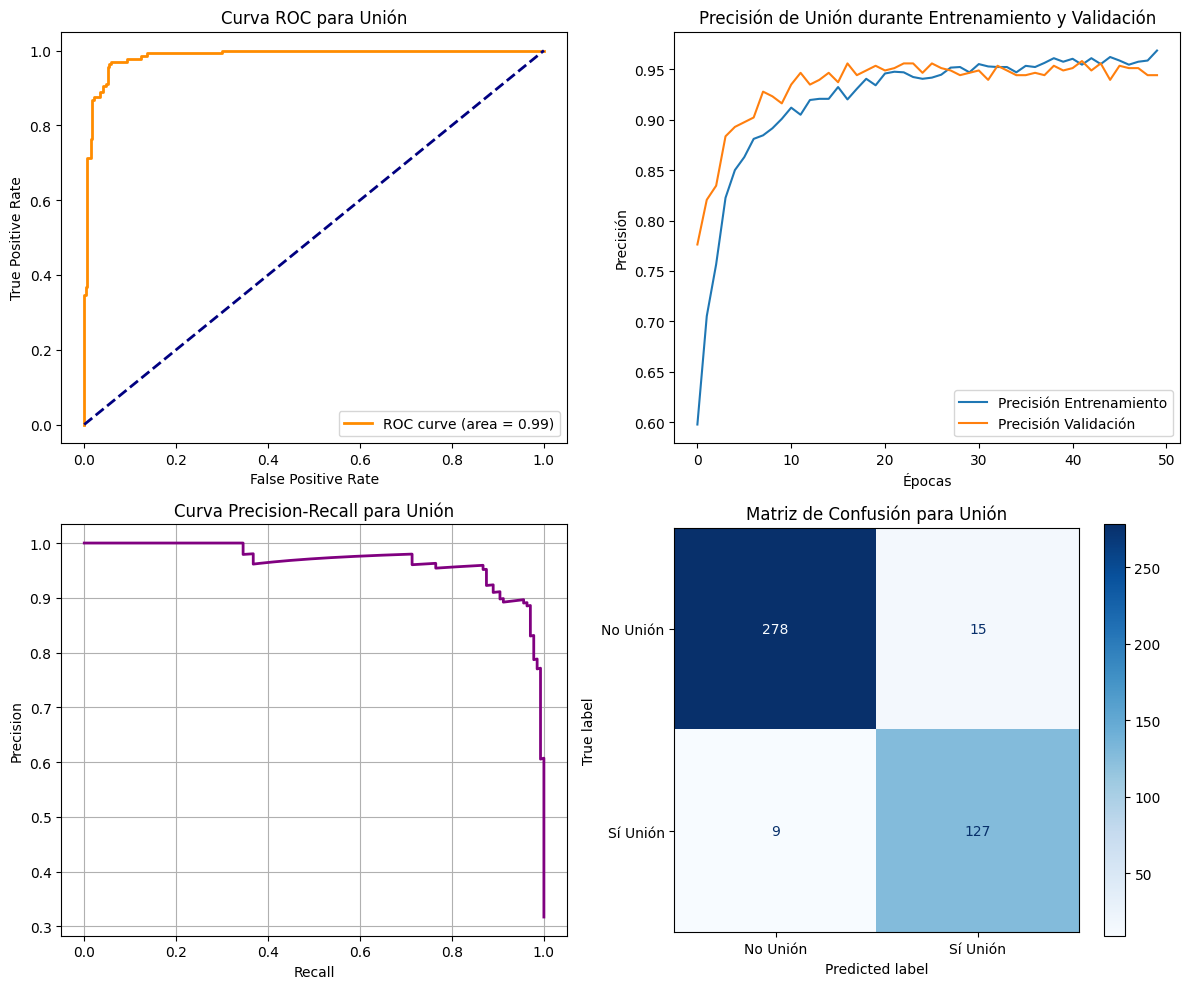

In [ ]:
# Gráficas de evaluación para Unión
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Curva ROC para Unión
fpr, tpr, _ = roc_curve(y_test_union, y_pred_union)
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_title('Curva ROC para Unión')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].legend(loc="lower right")

# Pérdida de entrenamiento y validación para Unión
axes[0, 1].plot(history.history['union_output_accuracy'], label='Precisión Entrenamiento')
axes[0, 1].plot(history.history['val_union_output_accuracy'], label='Precisión Validación')
axes[0, 1].set_title('Precisión de Unión durante Entrenamiento y Validación')
axes[0, 1].set_xlabel('Épocas')
axes[0, 1].set_ylabel('Precisión')
axes[0, 1].legend()

# Curva Precision-Recall para Unión
precision, recall, _ = precision_recall_curve(y_test_union, y_pred_union)
axes[1, 0].plot(recall, precision, lw=2, color='purple')
axes[1, 0].set_title('Curva Precision-Recall para Unión')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].grid()

# Matriz de Confusión para Unión
y_pred_union_binary = (y_pred_union.flatten() > 0.5).astype(int)
cm = confusion_matrix(y_test_union, y_pred_union_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Unión', 'Sí Unión'])
disp.plot(cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Matriz de Confusión para Unión')

plt.tight_layout()
plt.show()

## 3.3.1

In [ ]:
# Crear una tabla de métricas clave
metrics_data = {
    'Métrica': ['MAE (pChEMBL)', 'R² (pChEMBL)', 'Precisión (Unión)', 'AUC-ROC (Unión)'],
    'Valor': [pchembl_mae, r2, union_accuracy, roc_auc]
}
metrics_table = pd.DataFrame(metrics_data)

# Mostrar la tabla
print(metrics_table)


             Métrica     Valor
0      MAE (pChEMBL)  0.704921
1       R² (pChEMBL)  0.845792
2  Precisión (Unión)  0.944056
3    AUC-ROC (Unión)  0.985620


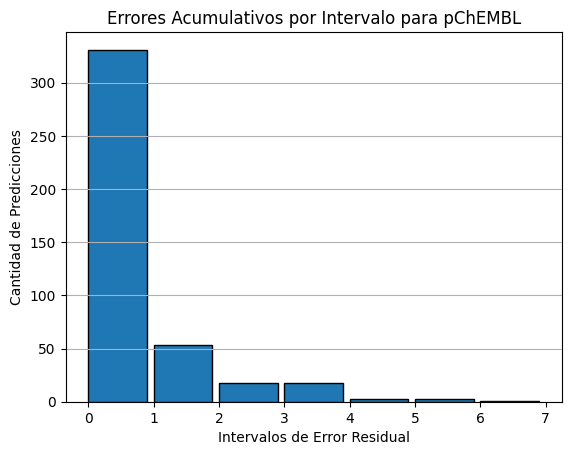

In [ ]:
# Crear histogramas de errores acumulativos por intervalos
error_bins = np.arange(0, max(abs(residuals)), 1)  # Dividir errores en intervalos
hist, bin_edges = np.histogram(abs(residuals), bins=error_bins)

# Graficar los errores acumulativos
plt.bar(bin_edges[:-1], hist, width=0.9, align='edge', edgecolor='black')
plt.xlabel('Intervalos de Error Residual')
plt.ylabel('Cantidad de Predicciones')
plt.title('Errores Acumulativos por Intervalo para pChEMBL')
plt.grid(axis='y')
plt.show()

## 3.3.2

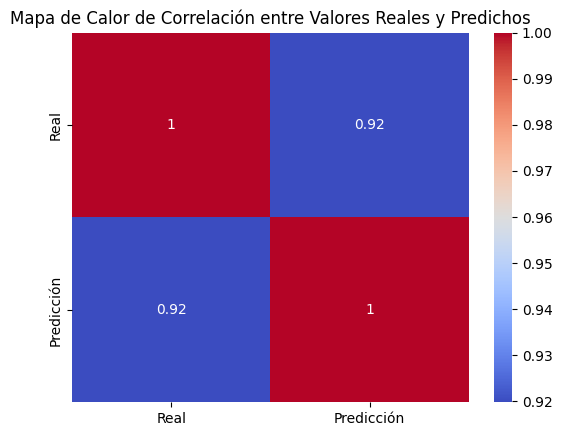

In [ ]:
# Crear un DataFrame con valores reales y predichos
comparison_data = pd.DataFrame({
    'Real': y_test_pchembl.flatten(),
    'Predicción': y_pred_pchembl.flatten()
})

# Calcular y graficar el heatmap de correlación
correlation_matrix = comparison_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación entre Valores Reales y Predichos')
plt.show()


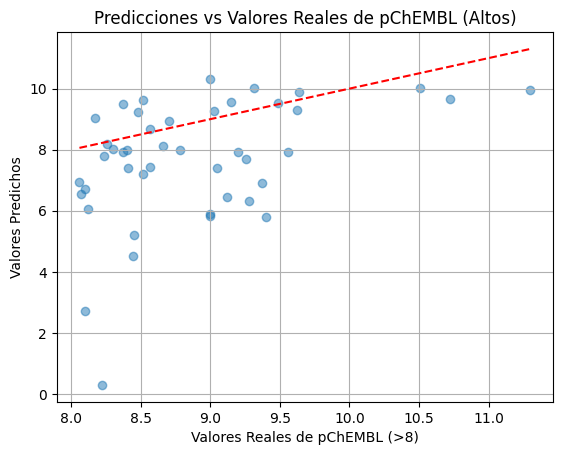

In [ ]:
# Filtrar datos con valores reales altos
filtered_data = comparison_data[comparison_data['Real'] > 8]

# Graficar dispersión para valores altos
plt.scatter(filtered_data['Real'], filtered_data['Predicción'], alpha=0.5)
plt.plot([min(filtered_data['Real']), max(filtered_data['Real'])],
         [min(filtered_data['Real']), max(filtered_data['Real'])],
         color='red', linestyle='--')
plt.xlabel('Valores Reales de pChEMBL (>8)')
plt.ylabel('Valores Predichos')
plt.title('Predicciones vs Valores Reales de pChEMBL (Altos)')
plt.grid()
plt.show()


## 3.3.3

In [ ]:
# Definir un umbral para casos atípicos
outlier_threshold = 3  # Por ejemplo, errores > 3 unidades
outliers = comparison_data[abs(residuals) > outlier_threshold]

# Mostrar los primeros casos atípicos
print("Casos Atípicos Identificados:")
print(outliers.head(10))

len(outliers)


Casos Atípicos Identificados:
      Real  Predicción
12   0.000    5.279311
20   0.000    3.600173
26   0.000    3.664535
83   3.940    0.173645
112  7.700    3.093468
115  3.740    0.182703
117  9.400    5.800966
138  8.455    5.212363
143  3.700    0.162716
151  4.770    7.823346


27

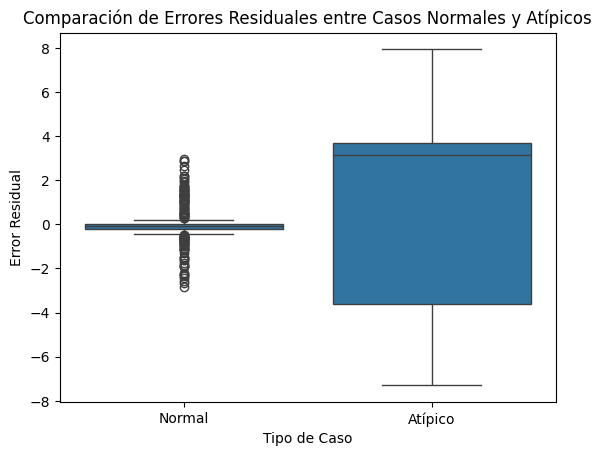

In [ ]:
# Etiquetar casos como normales o atípicos
comparison_data['Tipo'] = ['Atípico' if abs(err) > outlier_threshold else 'Normal' for err in residuals]

# Crear un boxplot comparativo
sns.boxplot(x='Tipo', y=residuals, data=comparison_data)
plt.title('Comparación de Errores Residuales entre Casos Normales y Atípicos')
plt.xlabel('Tipo de Caso')
plt.ylabel('Error Residual')
plt.show()


# Modelo

In [ ]:
model_save_path = './data/processed/deep_learning_pchembl_model_small.keras'
model.save(model_save_path)

In [ ]:
# Cargar el modelo y realizar predicciones
loaded_model = load_model(model_save_path)

# Solicitar entrada del usuario para realizar predicciones
print("Introduce los valores del ligando para realizar predicciones")

# Entrada del usuario para n_hot_fgs
n_hot_fgs_input = input("Introduce los valores para n_hot_fgs como una lista de 0s y 1s (por ejemplo, [1, 0, 0, 1]): ")
n_hot_fgs_input = np.array([ast.literal_eval(n_hot_fgs_input)])

# Entrada del usuario para One Hot Encoding
one_hot_input = input(f"Introduce los valores para One_Hot_Encoding como una lista de listas (de longitud {max_length}, cada lista de 0s y 1s): ")
one_hot_encoding_input = np.array([ast.literal_eval(one_hot_input)])

# Realizar padding si es necesario
one_hot_encoding_input = np.pad(one_hot_encoding_input, ((0, 0), (0, max_length - one_hot_encoding_input.shape[1]), (0, 0)), mode='constant')

# Realizar la predicción
pchembl_pred, union_pred = loaded_model.predict([one_hot_encoding_input, n_hot_fgs_input])

# Mostrar resultados
print(f"Predicción de pChEMBL: {pchembl_pred[0][0]}")
print(f"Predicción de Union (probabilidad de unión): {union_pred[0][0]}")
print(f"Resultado categórico de Union: {'Sí hay unión' if union_pred[0][0] > 0.5 else 'No hay unión'}")